In [1]:
import pandas as pd 
import pickle 


In [3]:
def get_fold(x):
    if x<50:
        return "Leave-pair-out"
    elif x<=100:
        return "LOOCV"
    elif x<=1000:
        return "StratifiedKFold n_splits = 10"
    else:
        return "StratifiedKFold n_splits = 5"


def turn_resDict_to_df(results,columns):
    all_df=[]
    for algo_name,fs_algo_lst in list(results.items())[:-3]:
        # database_name= results
        for k, k_res in list(fs_algo_lst.items())[:-1]:
            fs_time= fs_algo_lst["fs_algo"]
            chosen_features= k_res["chosen_features"]
            feature_rank= k_res["feature_rank"]
            for clf_name,clf_res in list(k_res.items())[2:]:
                for fold_name, fold_res in clf_res.items():
                    # print(fold_res)
                    infrence_time=fold_res["infrence_time"]
                    # del fold_res["infrence_time"]
                    temp_d=pd.DataFrame.from_dict(fold_res, orient='index')
                    temp_d.reset_index(inplace=True)
                    temp_d=temp_d.melt(id_vars='index')
                    temp_d.drop(columns=['variable'],inplace=True)
                    temp_d["infrence_time"]=[infrence_time]*temp_d.shape[0]
                    temp_d["Learning algorithm"]=[clf_name]*temp_d.shape[0]
                    temp_d["Number of features selected (K)"]=[k]*temp_d.shape[0]
                    temp_d["chosen_features"]=[chosen_features]*temp_d.shape[0]
                    temp_d["Selected Features scores"]=[feature_rank]*temp_d.shape[0]
                    temp_d["Filtering Algorithm"]=[algo_name]*temp_d.shape[0]
                    temp_d["Fold"]=[fold_name]*temp_d.shape[0]
                    temp_d["fs_time"]=[fs_time]*temp_d.shape[0]
                    all_df.append(temp_d.copy(deep=True))
    all_df=pd.concat(all_df, ignore_index=True)
    all_df["Dataset Name"]=results["Dataset Name"]
    all_df["Number of samples"]=results["Number of samples"]
    all_df["Original Number of features"]=results["Original Number of features"]
    all_df["chosen_features"]= all_df["chosen_features"].apply(lambda x: [columns[i] for i in x])
    all_df["CV Method"]=get_fold(results["Original Number of features"])
    return all_df


# t=turn_resDict_to_df(results,columns)


In [6]:

from os import listdir
from os.path import isfile, join
files= [f for f in listdir("results") if isfile(join("results", f))]

all_files=[]
for file in files:
    all_files.append(pd.read_csv("results/"+file,header=0))
    
df= pd.concat(all_files, ignore_index=True)
#rename index colum to metric
df.rename(columns={"index":"metric"},inplace=True)

In [12]:
def return_best_config(df):
    t= df[df["index"]=="accuracy"].groupby(["Filtering Algorithm","Number of features selected (K)","Learning algorithm"]).mean().reset_index()
    t=t.sort_values(by=["value"],ascending=False).iloc[0]
    return t

In [14]:
#calcalute the number of each Filtering Algorithm was able to achive the best performance in auc index
def mean_of_each_fold(df):
    t= df[df["metric"]=="PR-AUC"].groupby(["Dataset Name","Filtering Algorithm","Number of features selected (K)","Learning algorithm"]).mean().reset_index()
    
    # t=t.sort_values(by=["value"],ascending=False).iloc[0]
    return t
mean_auc_df= mean_of_each_fold(df)

In [17]:
def best_of_dataset(df):
    idx=df.groupby(['Dataset Name'])['value'].idxmax()
    t=df.loc[idx]
    return t
best_df= best_of_dataset(mean_auc_df)

In [19]:
# t= best_df.groupby("Filtering Algorithm")["Dataset Name"].count().reset_index()
# for algo in mean_auc_df["Filtering Algorithm"].unique():
#     if algo not in t["Filtering Algorithm"].unique():
#         t=t.append({"Filtering Algorithm":algo,"Dataset Name":0},ignore_index=True)

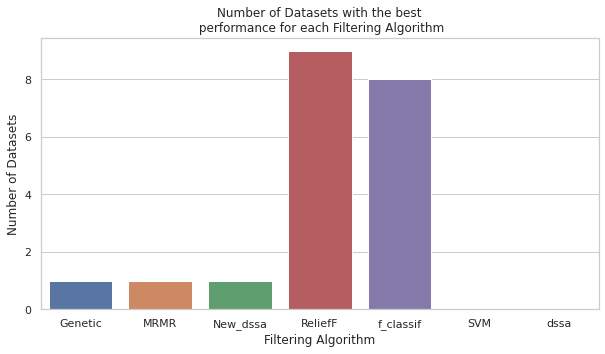

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
t= best_df.groupby("Filtering Algorithm")["Dataset Name"].count().reset_index()
for algo in mean_auc_df["Filtering Algorithm"].unique():
    if algo not in t["Filtering Algorithm"].unique():
        t=t.append({"Filtering Algorithm":algo,"Dataset Name":0},ignore_index=True)

# sns.barplot(best_df, x="Filtering Algorithm",)
plt.figure(figsize=(10,5))

sns.barplot(data= t,x="Filtering Algorithm",y="Dataset Name",)
#rename axis 
plt.xlabel("Filtering Algorithm")
plt.ylabel("Number of Datasets")
plt.title("Number of Datasets with the best\n performance for each Filtering Algorithm")
#change the fig size 
plt.show()

In [22]:
#fuller picture about the best performing algorithms
def rank_Filtering_of_dataset(df,all_rank=False):
    # t= df.groupby(["Dataset Name"])["value"].agg('max')
    if all_rank:
        t=df
    else:    
        idx=df.groupby(['Dataset Name',"Filtering Algorithm"])['value'].idxmax()
        n_algo= len(df["Filtering Algorithm"].unique())
        t=df.loc[idx]
    t.sort_values(by=["Dataset Name","value"],ascending=False,inplace=True)
    #group by and iterate over the dataset names and add the position of each algorithm in the list
    t["rank"]=n_algo-t.groupby(["Dataset Name"])["Filtering Algorithm"].cumcount()
    return t
algo_ranking= rank_Filtering_of_dataset(mean_auc_df)


<AxesSubplot:xlabel='Filtering Algorithm', ylabel='rank'>

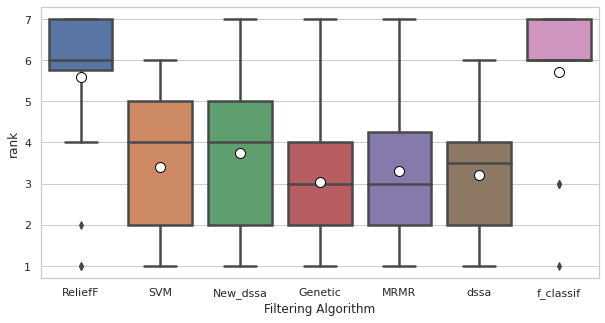

In [25]:
import seaborn as sns


plt.figure(figsize=(10,5))

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Filtering Algorithm", y="rank",data=algo_ranking,orient="v",linewidth=2.5,
            showmeans=True,  meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
# sns.swarmplot(x="Filtering Algorithm", y="rank",data=algo_ranking, color=".25")
# plt.ylim(reversed(plt.ylim()))
# sns.despine(offset=10, trim=True)

In [26]:
def bin_func(x):
    if x<=100:
        return "1-100"
    elif x<=200:
        return "100-200"
    return "200+"
df['binned_number_samples'] = pd.qcut(df['Number of samples'],q=3)


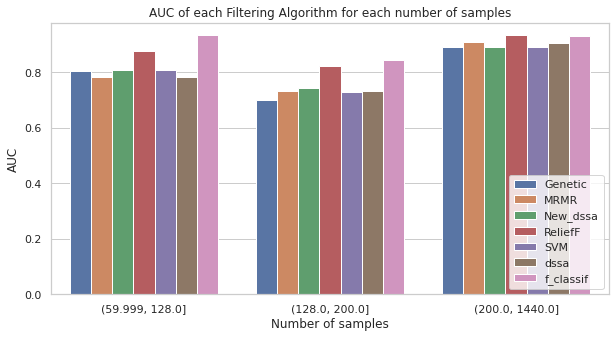

In [27]:
algo_ranking["bin_n_sample"]= pd.qcut(algo_ranking['Number of samples'],q=3)
temp=algo_ranking.groupby(["Dataset Name","bin_n_sample"])["value"].max().reset_index()
temp=algo_ranking.groupby(["bin_n_sample","Filtering Algorithm"])["value"].mean().reset_index()
# temp["Dataset Name"]=algo_ranking["Dataset Name"].unique()

plt.figure(figsize=(10,5))
sns.barplot(x="bin_n_sample", y="value", hue="Filtering Algorithm", data=temp)
#name the axis
plt.xlabel("Number of samples")
plt.ylabel("AUC")
plt.title("AUC of each Filtering Algorithm for each number of samples")
#move legend to the right bottom corner
plt.legend(loc="lower right")

plt.show()



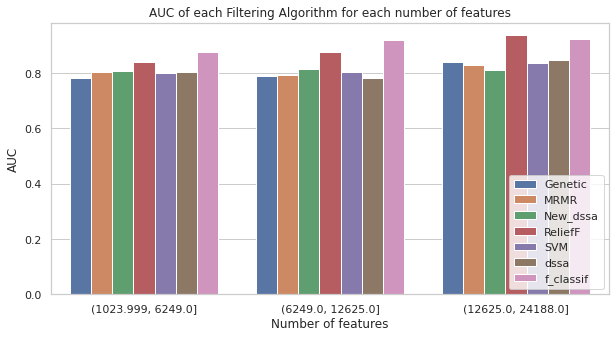

In [29]:
algo_ranking["bin_n_sample"]= pd.qcut(algo_ranking['Original Number of features'],q=3)
temp=algo_ranking.groupby(["Dataset Name","bin_n_sample"])["value"].max().reset_index()
temp=algo_ranking.groupby(["bin_n_sample","Filtering Algorithm"])["value"].mean().reset_index()
# temp["Dataset Name"]=algo_ranking["Dataset Name"].unique()

plt.figure(figsize=(10,5))
sns.barplot(x="bin_n_sample", y="value", hue="Filtering Algorithm", data=temp)
#name the axis
plt.xlabel("Number of features")
plt.ylabel("AUC")
plt.title("AUC of each Filtering Algorithm for each number of features")
#move legend to the right bottom corner
plt.legend(loc="lower right")

plt.show()



In [30]:
idx= mean_auc_df.groupby(["Dataset Name","Filtering Algorithm","Number of features selected (K)"])["value"].idxmax()
mean_auc_df["bin_n_sample"]= mean_auc_df["Number of samples"].apply(lambda x: bin_func(x))
mean_auc_df

,Dataset Name,Filtering Algorithm,Number of features selected (K),Learning algorithm,value,infrence_time,Fold,fs_time,Number of samples,Original Number of features
3,ARFF_Breast,Genetic,1,RandomForestClassifier,0.591304,3.241827,0.0,1122.572471,97.0,24188.0
7,ARFF_Breast,Genetic,2,LogisticRegression,0.499246,0.104856,0.0,1122.572471,97.0,24188.0
13,ARFF_Breast,Genetic,3,RandomForestClassifier,0.583100,3.182825,0.0,1122.572471,97.0,24188.0
18,ARFF_Breast,Genetic,4,RandomForestClassifier,0.523978,3.203051,0.0,1122.572471,97.0,24188.0
23,ARFF_Breast,Genetic,5,RandomForestClassifier,0.557947,3.205720,0.0,1122.572471,97.0,24188.0
...,...,...,...,...,...,...,...,...,...,...
8377,scikit_arcene,f_classif,20,LogisticRegression,0.786004,0.000039,4.5,0.073584,200.0,9961.0
8382,scikit_arcene,f_classif,25,LogisticRegression,0.802371,0.000040,4.5,0.073584,200.0,9961.0
8387,scikit_arcene,f_classif,30,LogisticRegression,0.794806,0.000035,4.5,0.073584,200.0,9961.0
8392,scikit_arcene,f_classif,50,LogisticRegression,0.822498,0.000034,4.5,0.073584,200.0,9961.0


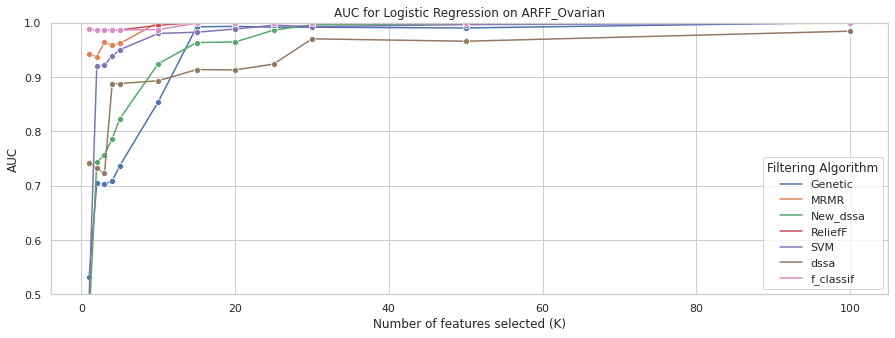

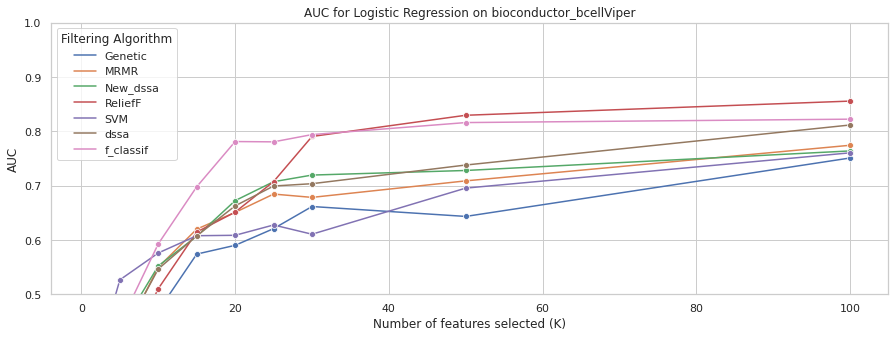

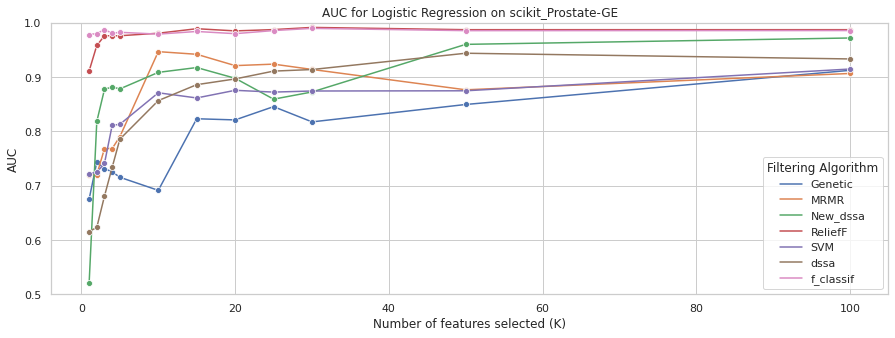

In [34]:
for dataset in ["ARFF_Ovarian", "bioconductor_bcellViper", "scikit_Prostate-GE"]:
    plt.figure(figsize=(15,5))
    data_set= mean_auc_df[(mean_auc_df["Dataset Name"]==dataset) & (mean_auc_df["Learning algorithm"]=="LogisticRegression")]
    sns.lineplot(data=data_set, x="Number of features selected (K)", y="value", hue="Filtering Algorithm",marker="o")
    #add markers to the points
    #name the axis
    plt.xlabel("Number of features selected (K)")
    plt.ylabel("AUC")
    plt.title("AUC for Logistic Regression on "+dataset)
    plt.ylim(0.5,1)
    plt.show()

# limit the y axis to the range [0.5,1]


Text(0.5, 0, 'Dataset Name')

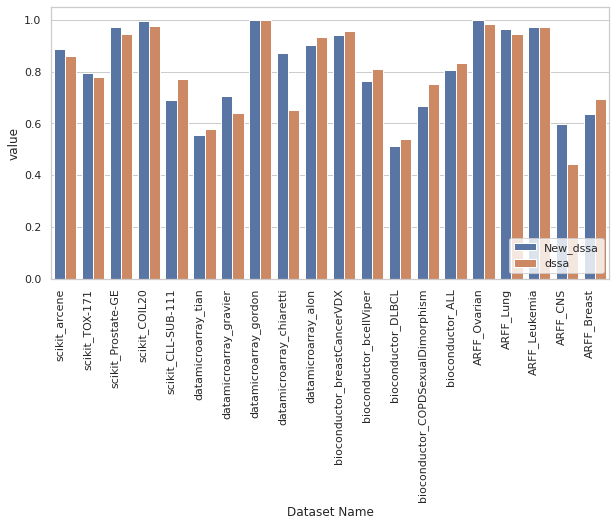

In [41]:
algo_ranking[algo_ranking["Dataset Name"]=="ARFF_Ovarian"]
temp_df= algo_ranking[(algo_ranking["Filtering Algorithm"]=="dssa") | (algo_ranking["Filtering Algorithm"]=="New_dssa")]
#bar plot for the performance of each algorithm for each dataset
plt.figure(figsize=(10,5))
ax=sns.barplot(x="Dataset Name", y="value", hue="Filtering Algorithm", data=temp_df)
#name the axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
#change y axis scale
# plt.ylim(0.5,1)
#legend location
plt.legend(loc="lower right")
plt.xlabel("Dataset Name")
